<a href="https://colab.research.google.com/github/HSE-LAMBDA/MLDM-2022/blob/master/07-trees/DecisionTrees_HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1 (3 points)

Generate a toy dataset for the "XOR" problem:

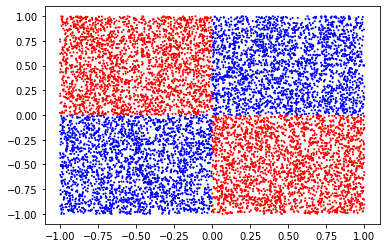

i.e. where the two features are distributed **uniformly** in $[-1, 1]$, and the target is $y = (x_0 >= 0) \text{ XOR } (x_1 >= 0)$.

Let the total number of points in the dataset be $N=10000$.

Fit a `sklearn.tree.DecisionTreeClassifier` on this data. Find a minimal `max_depth` value that results in train accuracy $>0.99$.

For each value of `max_depth` from 1 to the value found above, plot the data with the decision boundary for the obtained model. (*Hint: use `s=1` argument to `plt.scatter` to be able to see anything behind the data points.*)

For the model with train accuracy $>0.99$ use `sklearn.tree.plot_tree` to observe the tree structure.

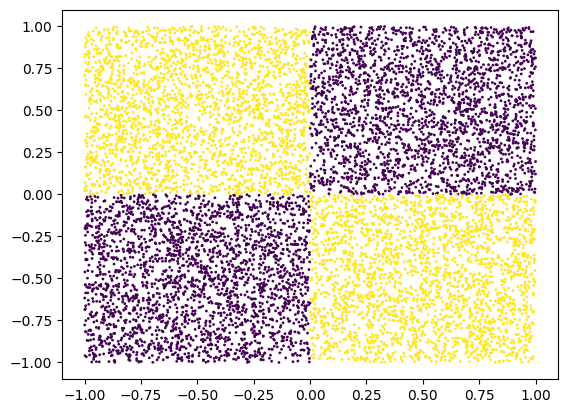

In [2]:
import numpy as np
import matplotlib.pyplot as plt

N = 10000
x_0 = np.random.uniform(-1, 1, N)
x_1 = np.random.uniform(-1, 1, N)
X = np.vstack((x_0, x_1)).T
y = np.logical_xor(X[:,0] >= 0, X[:,1] >= 0).astype(float)



plt.scatter(X[:,0], X[:,1], s=1, c=y)

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
trees = []

for depth in range(1, 6):
    model = DecisionTreeClassifier(max_depth=depth)
    model.fit(X_train, y_train)
    trees.append(model)
    prediction = model.predict(X_test)
    score = accuracy_score(y_test, prediction)
    print(f"Accuracy for max_depth {depth} is {score:.3f}")

    if score > 0.99:
        break

Accuracy for max_depth 1 is 0.492
Accuracy for max_depth 2 is 0.539
Accuracy for max_depth 3 is 0.942
Accuracy for max_depth 4 is 1.000


Text(0.5, 0.98, 'Decision tree boundaries for different depth values')

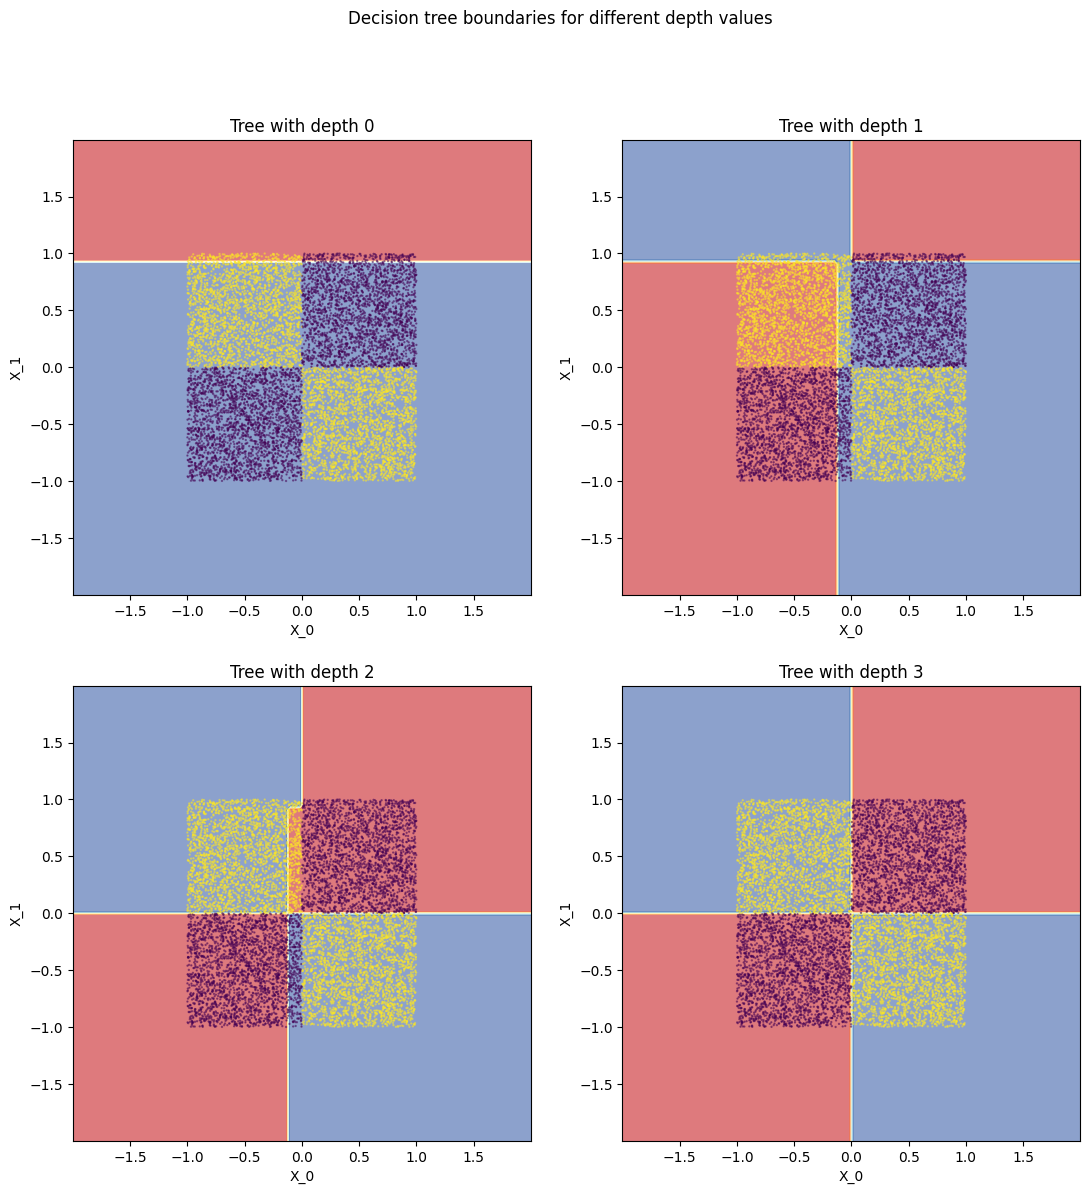

In [66]:
from sklearn.inspection import DecisionBoundaryDisplay

plt.figure(figsize=(13,13))
for i in range(len(trees)):
    ax = plt.subplot(2, 2, i + 1)
    disp = DecisionBoundaryDisplay.from_estimator(
        trees[i],
        X,
        response_method="predict",
        ax=ax,
        cmap=plt.cm.RdYlBu,
        alpha=0.6,
        xlabel="X_0",
        ylabel="X_1"
    )
    disp.ax_.scatter(X[:,0], X[:,1], s=0.5, c=y, alpha=0.5)
    disp.ax_.set_title(f"Tree with depth {i}")
plt.suptitle("Decision tree boundaries for different depth values")

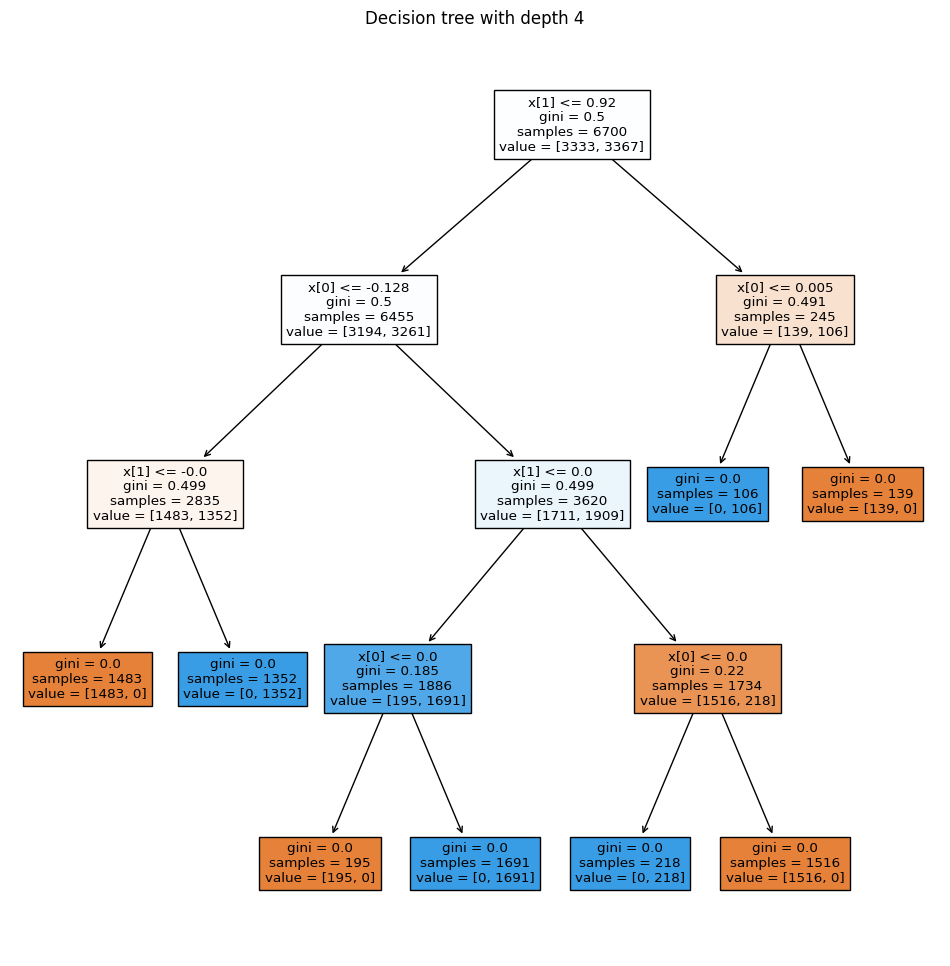

In [65]:
from sklearn.tree import plot_tree

plt.figure(figsize=(12, 12))
plot_tree(trees[-1], filled=True)
plt.title(f"Decision tree with depth {len(trees)}")
plt.show()

# Task 2 (3 points)

Consider the following dataset:

In [69]:
import pandas as pd
from sklearn.model_selection import train_test_split

from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
print(data.DESCR)

X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target_names[data.target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12345)

print(X_train.iloc[:5])
print(y_train[:5])

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

Build a `sklearn.tree.DecisionTreeClassifier` to maximize the test ROC AUC score.

When predicting cancer, it's much more dangerous to have a false negative prediction rather than false positive. Try to find the best tree (in terms of test ROC AUC) where the labels are re-weighted with the `class_weight={'malignant' : 2., 'benign' : 1.}` argument provided to the `DecisionTreeClassifier` constructor.

Plot test ROC curves for the two best models you found on the same plot.

In [84]:
%%time
from sklearn.model_selection import GridSearchCV

parameters = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None] + list(range(1, 16)),
    'max_features': [None, 'sqrt', 'log2'],
    'min_samples_split': range(2, 11),
    'min_samples_leaf': range(1, 100, 5),
}

model = DecisionTreeClassifier(random_state=42, class_weight={'malignant' : 2., 'benign' : 1.})
clf = GridSearchCV(
    model,
    parameters,
    cv=5,
    scoring='roc_auc',
    verbose=1,
    n_jobs=-1
)
clf.fit(X_train, y_train)

best_tree_model = clf.best_estimator_
print(clf.best_params_)
print("ROC AUC: ", clf.best_score_)

Fitting 5 folds for each of 17280 candidates, totalling 86400 fits
{'criterion': 'gini', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 16, 'min_samples_split': 2}
ROC AUC:  0.979470411663808
CPU times: user 29.2 s, sys: 1.29 s, total: 30.5 s
Wall time: 38.8 s


In [85]:
%%time
from sklearn.model_selection import GridSearchCV

parameters = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None] + list(range(1, 16)),
}

model = DecisionTreeClassifier(random_state=42, class_weight={'malignant' : 2., 'benign' : 1.})
clf = GridSearchCV(
    model,
    parameters,
    cv=5,
    scoring='roc_auc',
    verbose=1,
    n_jobs=-1
)
clf.fit(X_train, y_train)

best_tree_model_2 = clf.best_estimator_
print(clf.best_params_)
print("ROC AUC: ", clf.best_score_)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
{'criterion': 'entropy', 'max_depth': 2}
ROC AUC:  0.9670972698684963
CPU times: user 138 ms, sys: 21.3 ms, total: 159 ms
Wall time: 328 ms


In [93]:
# Validation
from sklearn.metrics import roc_auc_score

prediction = best_tree_model.predict_proba(X_test)[:, 1]
score = roc_auc_score(y_test, prediction)
print(f"Roc auc for top 1 model: {score:.3f}")

prediction = best_tree_model_2.predict_proba(X_test)[:, 1]
score = roc_auc_score(y_test, prediction)
print(f"Roc auc for top 2 model: {score:.3f}")

Roc auc for top 1 model: 0.943
Roc auc for top 2 model: 0.928


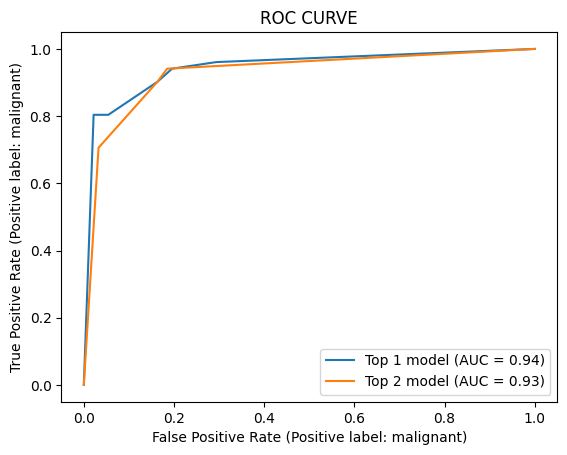

In [116]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay


curv = RocCurveDisplay.from_estimator(best_tree_model, X_test, y_test, pos_label="malignant", name="Top 1 model") 
curv.ax_.set_title("ROC CURVE")
curv2 = RocCurveDisplay.from_estimator(best_tree_model_2, X_test, y_test, pos_label="malignant", name="Top 2 model", ax=curv.ax_) 